In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers, Model
import tensorflow as tf
from PIL import Image


(178, 218)
RGB
JPEG


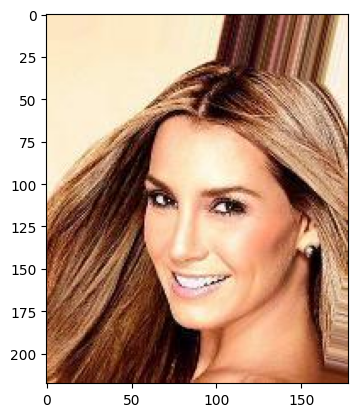

In [2]:
img = Image.open('img_align_celeba_1/10k_img/000001.jpg')
print(img.size)
print(img.mode)
print(img.format)
plt.imshow(img)
plt.show()

In [3]:
images = []
for i in range(1, 10001):
    img = Image.open('img_align_celeba_1/10k_img/{:06d}.jpg'.format(i))
    img = np.array(img)
    images.append(img)

images = np.array(images)
images = images / 255.0
print(images.shape)
latent_dim = 14*12
print(latent_dim)

(10000, 218, 178, 3)
168


In [4]:
class Autoencoder(Model):
    def __init__(self, latent_dim, input_shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.input_shape_ = input_shape

        # Encoder: CNN layers with decreasing spatial dimensions
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=input_shape),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),  # Downsample to 109x89
            
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),  # Downsample to 55x45
            
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),  # Downsample to 28x23
            
            layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),  # Downsample to 14x12
            
            layers.Conv2D(latent_dim, (3, 3), activation='relu', padding='same'),  # Latent space
        ])

        # Decoder: CNN layers with increasing spatial dimensions
        self.decoder = tf.keras.Sequential([
            layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),  # Upsample to 28x24
            
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),  # Upsample to 56x48
            
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),  # Upsample to 112x96
            
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),  # Upsample to 224x192

            # Cropping layer to return the exact original size
            layers.Cropping2D(((3, 3), (7, 7))),  # Crop to return to 218x178

            # Final layer to reconstruct the 3-channel image
            layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'),  # Output shape: 218x178x3
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


print(images.shape[1:])


(218, 178, 3)


In [5]:
autoencoder = Autoencoder(latent_dim, images.shape[1:])
images_test = images[:1000]
images_train = images[1000:]
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(images_train, images_train, shuffle=True, epochs=25, validation_data=(images_test, images_test))

  warnings.warn(


Epoch 1/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 264s 932ms/step - loss: 0.0360 - val_loss: 0.0072
Epoch 2/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 265s 939ms/step - loss: 0.0067 - val_loss: 0.0049
Epoch 3/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 265s 940ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 4/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 265s 940ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 5/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 265s 939ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 6/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 265s 939ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 7/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 266s 942ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 8/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 265s 940ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 9/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 265s 939ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 10/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 265s 940ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 11/25
282/282 ━━━━━━━━━━━━━━━━━━━━ 265s 939ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 12

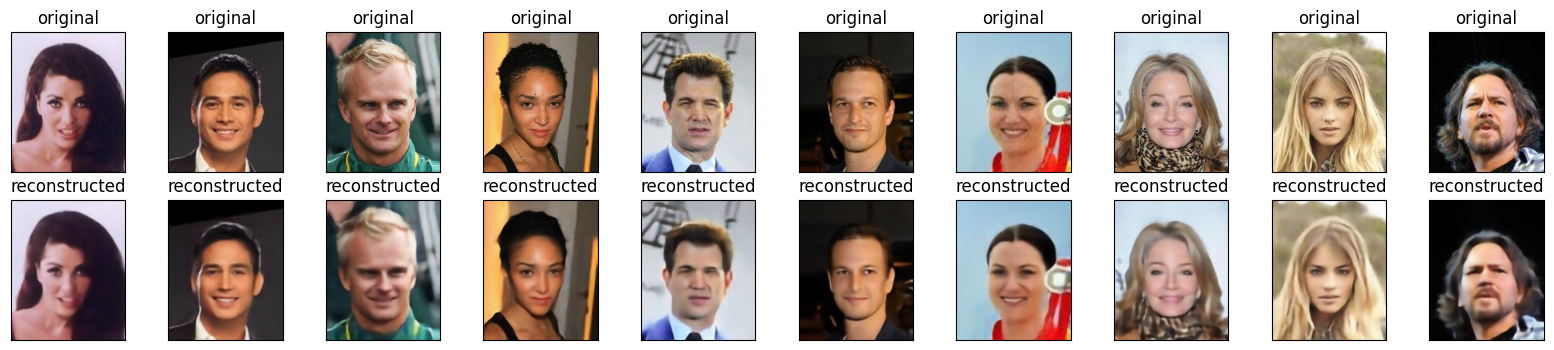

In [8]:
encoded_imgs = autoencoder.encoder(images_test[:30]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(images_test[10+i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[10+i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
autoencoder.save('autoencoder.keras')